In [11]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import scipy as sc

# Task B: Reconstruct Density matrix from Wigner function

In this task, we are given a Wigner function and must obtain a density matrix. To do this, we first define the displacement and parity operators, along with an observable:

$$ D(\alpha) = exp(\alpha \hat{a}^\dagger - \alpha \hat{a}), P = exp(i\pi \hat{a}^\dagger \hat{a}), E_{\alpha} = 1/2(I + D(\alpha)PD^\dagger(\alpha)) $$

We can also obtain expected measurement outcomes for eahc displacement $\alpha_k$:

$$ w_k = 1/2(1 + \pi/2*W(\alpha_k)) $$

We find $\rho$ by minimizing the loss function:

$$ L(\rho) = \Sigma|Tr(|E_{\alpha k} \rho - p_{\alpha k}|^2) $$

This is a convex optimization problem, and we can impose the constraints that the trace must equal 1, all entries must be positive, and the matrix must be Hermitian. We utilize the cvxpy package to find the matrix that minimizes this function. 


We utilize batches to conserve memory use, and run the minimization function on each batch. Instead of running independent minimizations, we feed the output density matrix from one batch into the initial guess of the next batch. This iteratively improves the matrix estimation over the batches. We also use JAX to speed up matrix operations when forming the observables. JAX resulted in a speedup of around 30x, and the use of batching resulted in a speedup of around 5x. 

In [4]:
import numpy as np
from dynamiqs import destroy, expm, QArray

#functions for operators

def displacement(N, alpha):
    '''
    N (int) = hilbert space dimension
    alpha (complex number) = displacement

    returns (QArray) displacement operator with value alpha
    '''
    a = destroy(N)
    generator = alpha * a.dag() - jnp.conj(alpha) * a

    # exponential
    D = expm(generator) 
    return D

def parity(N):
    '''
    N (int) = hilbert space dimension

    returns (QArray) parity operator
    '''
    a = destroy(N)
    i = 1j
    generator = i * jnp.pi * a.dag() @ a
    P = expm(generator)
    return P


def observable(N, alpha):
    '''
    N (int) = hilbert space dimension
    alpha (complex number) = displacement

    returns (QArray) observable with value alpha
    '''    

    N_big = N + 10 #create operator with larger dimension
    D_big = displacement(N_big, alpha)
    P_big = parity(N_big)
    E_big = 0.5 * (jnp.eye(N_big) + D_big @ P_big @ D_big.conj().mT)


    # Truncate back
    E = E_big.data[:N, :N]

    return E


In [5]:
def get_W_at_alphas(xvec, yvec, w, alphas):
    '''
    W (2D array) wigner state values
    xvec (1d array) position axis values
    yvec (1d array) momentum axis values
    alphas (1d array of complex) where to evaluate the wigner function at

    returns (array) values of wigner function at alphas
    '''
    x = alphas.real
    y = alphas.imag


    #find closest index to alpha value
    ix = np.abs(xvec[:, None] - x[None, :]).argmin(axis=0)
    iy = np.abs(yvec[:, None] - y[None, :]).argmin(axis=0)

    return w[ix, iy]
    

In [6]:

def generate_coherent_state_alphas(
    alpha0 = 0,           # complex, center of coherent state
    num_points=1000,  
    radius=3.0,       # how far out to sample from center (input into np.random.uniform)
    num_batches=1,    # number of batches to divide into
    seed=None         #
):
    if seed is not None:
        np.random.seed(seed)

    # Sample points in polar coords
    r = np.sqrt(np.random.uniform(0, radius**2, num_points))
    theta = np.random.uniform(0, 2 * np.pi, num_points)

    # Convert to complex, then shift by alpha0
    alphas = (r * np.exp(1j * theta)) + alpha0

    # Convert to Wigner
    alphas *= np.sqrt(2)

    # Batch splitting
    if num_batches > 1:
        usable_points = (num_points // num_batches) * num_batches
        alphas = alphas[:usable_points]
        batches = np.split(alphas, num_batches)
        return np.array(batches)
    else:
        return alphas

In [7]:
def density_from_wigner(xvec, yvec, w, alpha0, num_points, num_batches, radius, N, fock=False):
    '''
    xvec, yvec, w - output from dq.wigner(state)
    alpha0 - center of wigner function
    num_points - number of alphas to sample
    num_batches - batches to split up the points into for faster calculation
    radius - radius around center to sample points from
    N - hilbert space dimension used for calculate (should be larger than size of state)
    fock - (bool) If true, begins optimization with a diagonal matrix which improves results

    '''

    alpha_batches = generate_coherent_state_alphas(alpha0=alpha0, num_points=num_points, num_batches=num_batches, radius=radius)

    #generate probabilities w_k and observables E_k for each batch of alphas

    probs_batches = []
    for alphas in alpha_batches:
        W_at_alphas = get_W_at_alphas(xvec*np.sqrt(2), yvec*np.sqrt(2), w, alphas)
        probs = 0.5*(1+(np.pi/2)*(W_at_alphas))
        probs_batches.append(probs)
    probs_batches = np.array(probs_batches)
    print('done with probs')

    ops_batches = []
    for alphas in alpha_batches:
        vmapped_observable = jax.vmap(lambda alpha: observable(N, alpha))
        results = vmapped_observable(alphas)
        ops_batches.append(results)
    ops_batches = np.array(ops_batches)

    #hilbert space dimension
    rho = 0 #make sure rho has been reset between function runs
    rho = cp.Variable((N, N), complex=True)
    constraints = [rho >> 0, cp.trace(rho) == 1, rho.H == rho]

    i = 0
    for ops_batch, probs_batch in zip(ops_batches, probs_batches):
        print('calculating batch', i)
        i += 1

        if fock and rho.value is None:
            rho.value = np.eye(N, dtype=complex) / N  # Set initial guess once if fock is selected

        predicted = cp.vstack([cp.real(cp.trace(E @ rho)) for E in ops_batch])
        loss = cp.sum_squares(predicted - probs_batch)
        objective = cp.Minimize(loss)
        prob = cp.Problem(objective, constraints)
        prob.solve(cp.SCS)
        print(f"Solver status: {prob.status}")

    return rho.value

    



We need to generate a set of samples $\alpha_k$ which accurately represent the data with a relatively small number of points. The interesting part of the Wigner functions are concentrated around the center, so we generate points within a radius r around a user defined center $\alpha_0$. We also use a uniform distribution within polar coordinates to get an even spread of points. This is handled within the generate_coherent_state_alphas() function. We illustrate how this distribution captures the center of the Fock function.

In [87]:
fock = dq.states.fock
state = fock(5, 1)
xvec, yvec, w = dq.wigner(state)

alpha_batches = generate_coherent_state_alphas(alpha0=0, num_points=2000, num_batches=20, radius=1.2)
alphas_flat = []
for batch in alpha_batches:
    for alpha in batch:
        alphas_flat.append(alpha)

w_flat = get_W_at_alphas(xvec, yvec, w, np.array(alphas_flat))

In [88]:
x_list = []
y_list = []
for alpha in alphas_flat:
    x = np.real(alpha)
    y = np.imag(alpha)
    x_list.append(x)
    y_list.append(y)

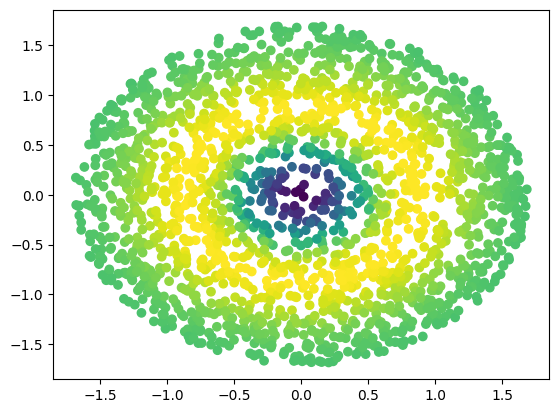

In [89]:
plt.scatter(x_list, y_list, c=w_flat)

We evaluate the accuracy of our estimated density matrix using Fidelity and Trace Distance. Fidelity is defined as:

$$ F(\rho, \tilde{\rho}) = (Tr\sqrt{\sqrt{\rho}\tilde{\rho}\sqrt{\rho}})^2 $$

Where $\rho$ is the actual density matrix and $\tilde{\rho}$ is the estimated matrix. Fidelities closer to 1 indicate the two matrices are more similar. 

The trace distance is defined as:

$$1/2\Sigma^r_{i=1}|\lambda_i| $$

Where $\lambda_i$ are the eigenvalues of the matrix $\rho - \tilde{\rho} $

In [18]:
def fidelity(rho_true, rho_est):
    """Compute the fidelity between two density matrices, rho_true and rho_est."""
    rho_true = np.real(rho_true)
    rho_est = np.real(rho_est)
    sqrt_rho = sc.linalg.sqrtm(rho_true)
    intermediate = sqrt_rho @ rho_est @ sqrt_rho
    sqrt_intermediate = sc.linalg.sqrtm(intermediate)
    return np.real(np.trace(sqrt_intermediate))**2



def trace_distance(rho1, rho2):
    """
    trace_distance function has two inputs, the two density matrices you plan on comparing. And then uses the formula for trace distance to compare
    the two density matrices, the lower the value the more similar the matrices.
    """ 
    eigvals = np.linalg.eigvalsh(rho1 - rho2) #Gets the eigenvalues of the difference in the density matrices
    trace_dist = 0.5 * np.sum(np.abs(eigvals)) #Gets the sum of the differences in the trace *.5 to get the Trace Distance
    return trace_dist

## Obtain Density Matrices for Fock, Coherent, and Cat state

We then initialize these three states using Dynamiqs and obtain the estimated density matrix using the density_from_wigner() function defined above. We also get the actual density matrix from Dynamiqs. 

In [68]:
#set up states and get density matrices
fock = dq.states.fock
state = fock(5, 1)
xvec, yvec, w = dq.wigner(state)
real_rho_fock = dq.states.fock_dm(5, 1) #real density matrix
est_rho_fock = density_from_wigner(xvec, yvec, w, alpha0=0, num_points=2000, num_batches=20, radius=1.2, N=10, fock=False)



done with probs
calculating batch 0
Solver status: optimal
calculating batch 1
Solver status: optimal
calculating batch 2
Solver status: optimal
calculating batch 3
Solver status: optimal
calculating batch 4
Solver status: optimal
calculating batch 5
Solver status: optimal
calculating batch 6
Solver status: optimal
calculating batch 7
Solver status: optimal
calculating batch 8
Solver status: optimal
calculating batch 9
Solver status: optimal
calculating batch 10
Solver status: optimal
calculating batch 11
Solver status: optimal
calculating batch 12
Solver status: optimal
calculating batch 13
Solver status: optimal
calculating batch 14
Solver status: optimal
calculating batch 15
Solver status: optimal
calculating batch 16
Solver status: optimal
calculating batch 17
Solver status: optimal
calculating batch 18
Solver status: optimal
calculating batch 19
Solver status: optimal


In [76]:

coherent = dq.states.coherent
state = coherent(10, 2)
xvec, yvec, w = dq.wigner(state)
real_rho_coh = dq.states.coherent_dm(10, 2) #real density matrix
est_rho_coh = density_from_wigner(xvec, yvec, w, alpha0=2, num_points=2000, num_batches=20, radius=1.2, N=10, fock=False)

done with probs


/home/brookc3/quantum/.venv/lib/python3.12/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)


calculating batch 0


/home/brookc3/quantum/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:407: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Solver status: optimal
calculating batch 1
Solver status: optimal
calculating batch 2
Solver status: optimal
calculating batch 3
Solver status: optimal
calculating batch 4
Solver status: optimal
calculating batch 5
Solver status: optimal
calculating batch 6
Solver status: optimal
calculating batch 7
Solver status: optimal
calculating batch 8
Solver status: optimal
calculating batch 9
Solver status: optimal
calculating batch 10
Solver status: optimal
calculating batch 11
Solver status: optimal
calculating batch 12
Solver status: optimal
calculating batch 13
Solver status: optimal
calculating batch 14
Solver status: optimal
calculating batch 15
Solver status: optimal
calculating batch 16
Solver status: optimal
calculating batch 17
Solver status: optimal
calculating batch 18
Solver status: optimal
calculating batch 19
Solver status: optimal


In [9]:
# #2-Cat State
state = (dq.coherent(10, 1) + dq.coherent(10, -1)).unit()
xvec, yvec, w = dq.wigner(state)
real_rho_cat = dq.coherent_dm(10, 1) + dq.coherent_dm(10, -1)
est_rho_cat = density_from_wigner(xvec, yvec, w, alpha0=0, num_points=2000, num_batches=20, radius=1.2, N=10, fock=False)

done with probs


/home/brookc3/quantum/.venv/lib/python3.12/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)


calculating batch 0


/home/brookc3/quantum/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:407: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Solver status: optimal
calculating batch 1
Solver status: optimal
calculating batch 2
Solver status: optimal
calculating batch 3
Solver status: optimal
calculating batch 4
Solver status: optimal
calculating batch 5
Solver status: optimal
calculating batch 6
Solver status: optimal
calculating batch 7
Solver status: optimal
calculating batch 8
Solver status: optimal
calculating batch 9
Solver status: optimal
calculating batch 10
Solver status: optimal
calculating batch 11
Solver status: optimal
calculating batch 12
Solver status: optimal
calculating batch 13
Solver status: optimal
calculating batch 14
Solver status: optimal
calculating batch 15
Solver status: optimal
calculating batch 16
Solver status: optimal
calculating batch 17
Solver status: optimal
calculating batch 18
Solver status: optimal
calculating batch 19
Solver status: optimal


## Compare Estimated Density matrix vs actual density matrix

Here, we visualize the matrices and then compare the fidelity and trace distance.

For the Fock state, we calculated a the density matrix using a Hilbert space dimension of 10, but the actual fock state has a hilbert dimension of 5. This was done to avoid edge affects and increase accuracy. To compare with the actual density matrix, we truncate and then renormalize the trace to 1. 

We did not use this technique for the other states to limit computation time. 

Fidelity: 0.28024548
Trace Distance 0.7233563


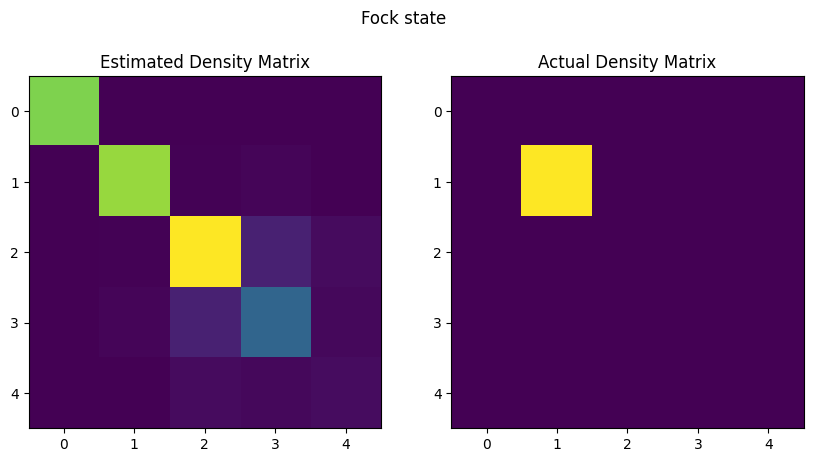

In [81]:
#Fock state

truncated_rho = est_rho_fock[:5, :5]
truncated_rho = truncated_rho/np.trace(truncated_rho)
truncated_rho[truncated_rho < 0] = 0


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(np.real(truncated_rho))
ax1.set_title('Estimated Density Matrix')

ax2.imshow(np.real(real_rho_fock))
ax2.set_title('Actual Density Matrix')

fig.suptitle('Fock state')

fid = fidelity(truncated_rho, real_rho_fock)
td = trace_distance(truncated_rho, real_rho_fock)

print('Fidelity:', fid)
print('Trace Distance', td)


Fidelity: 0.32722875
Trace Distance 0.726933


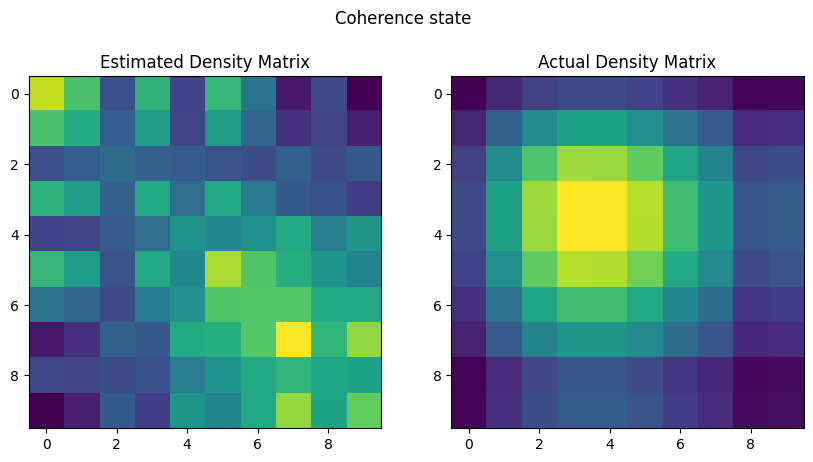

In [84]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(np.real(est_rho_coh))
ax1.set_title('Estimated Density Matrix')

ax2.imshow(np.real(real_rho_coh))
ax2.set_title('Actual Density Matrix')

fig.suptitle('Coherence state')

fid = fidelity(est_rho_coh, real_rho_coh)
td = trace_distance(est_rho_coh, real_rho_coh)

print('Fidelity:', fid)
print('Trace Distance', td)

Fidelity: 1.0641905052244653
Trace Distance 1.0031091


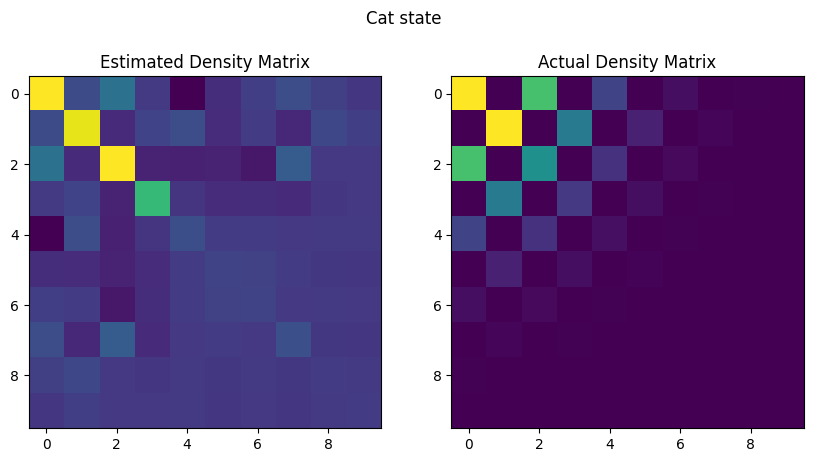

In [19]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(np.real(est_rho_cat))
ax1.set_title('Estimated Density Matrix')

ax2.imshow(np.real(real_rho_cat))
ax2.set_title('Actual Density Matrix')

fig.suptitle('Cat state')

fid = fidelity(est_rho_cat, real_rho_cat)
td = trace_distance(est_rho_cat, real_rho_cat)

print('Fidelity:', fid)
print('Trace Distance', td)

To recap:

We created a function to generate a density matrix from a Wigner function. We estimated the density matrices for a Fock, Coherent, and Cat state. We evaluated these estimates using Fidelity and Trace distance. 